# Assignment 5

# **Assignment 5**

Goal of the assignment: ​Get familiar with neural architecture search by applying an evolutionary algorithm to select the best architecture of a neural network.

# Import libraries

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import SVHN
from torchvision.transforms import ToTensor
from torch.utils.data import random_split

EPS = 1.0e-7

# Mount Drive

In [2]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# mount drive: WE NEED IT FOR SAVING IMAGES!
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# PLEASE CHANGE IT TO YOUR OWN GOOGLE DRIVE!
result_dir = "/content/gdrive/MyDrive/Colab Notebooks/assignment_5"

# Digits dataset (from Assignment 4)

In [4]:
# This is a class for the dataset of small (8px x 8px) digits.
# Please try to understand in details how it works!
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

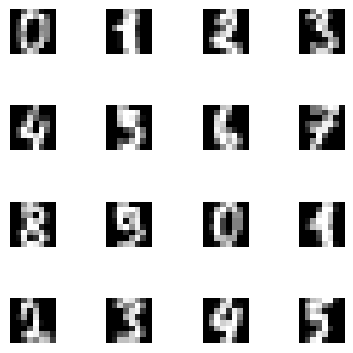

In [5]:
# Here, we plot some images (8px x 8px).
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4, 4, figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
    for j in range(4):
        img = np.reshape(x[4 * i + j], (8, 8))
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis("off")

# Helper modules (Flatten and Reshape)

Below, we have two helper modules (layers) that can be used to reshape and flatten a tensor. They are useful for creating sequentials with convolutional layers.

In [6]:
# Here are two auxiliary functions that can be used for a convolutional NN (CNN).

# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size  # a list

    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)


# This module flattens an input (tensor -> matrix) by blending dimensions
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

# Neural Network Classifier (from Assignment 4)

Below is the main class for a classifier parameterized by a neural network.

In [7]:
# Implement a neural network (NN) classifier.
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        self.classnet = classnet
        # The loss function (the negative log-likelihood)
        self.nll = nn.NLLLoss(reduction="none")  # it requires log-softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        # output is taken from classnet
        out = self.classnet(x)
        # index of maximum value and assign it to predicted one
        _, y_pred = torch.max(out, dim=1)
        #return predicted label
        return y_pred

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction="avg"):
        # get output from classnet 
        out = self.classnet(x)
        # compute loss from self.nll between output and y
        loss = self.nll(out, y)       
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

# Evaluation (from Assignment 4)

In [8]:
def evaluation(test_loader, name=None, model_best=None, epoch=None, print_freq=1):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model")

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error


# An auxiliary function for plotting the performance curves
def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

# Training procedure (from Assignment 4)

In [9]:
# The training procedure
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader, print_freq
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e, print_freq=print_freq)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

#Experiments

# Initialize dataloaders (from Assignment 4)

In [10]:
# Initialize training, validation and test sets.
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

# Initialize data loaders.
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [11]:
print("How do we get our data from Digits class? \n")
print(f"Feature example: {train_data[1][0]}")
print(f"Label example: {train_data[1][1]}")

How do we get our data from Digits class? 

Feature example: [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
  3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
 16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
  0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
Label example: 1


# Creating CNN Generator Class

We create dictionaries for Convolutional number of filters, convolutional layer configurations, pooling dimensions, pooling type, number of neurons in neural layer, and activation function. 

We implemented  a convolutional neural network of the following form:
Conv2d → f(.) → Pooling → Flatten → Linear 1 → f(.) → Linear 2 → Softmax 

We have different choices in each building block:


*   Conv2d: Number of filters: 8, 16, 32 / kernel=(3,3), stride=1, padding=1 OR kernel=(5,5), stride=1, padding=2
*  f(.): ReLU OR sigmoid OR tanh OR softplus OR ELU
*   Pooling: 2x2 OR Identity
 Average OR Maximum
*   Linear 1: Number of neurons: 10, 20, 30, 40, 50, 60, 70, 80, 90, 100

In [12]:
conv_num_filters = {
    0: 8,
    1: 16,
    2: 32
}

conv_configs = {
    0: 'config0',
    1: 'config1'
}

pooling_dims = {
    0: (2,2),
    1: (1,1)
}

pooling_type = {
    0: 'average',
    1: 'maximum'
}

linear_num_neurons = {
    0: 10,
    1: 20,
    2: 30,
    3: 40,
    4: 50,
    5: 60,
    6: 70,
    7: 80,
    8: 90,
    9: 100
}

activation = {
    0: 'ReLU',
    1: 'sigmoid',
    2: 'tanh',
    3: 'softplus',
    4: 'ELU'
}

In [13]:
class CNNGenerator():
 
  def create_population(self, pop_size):
    # generates a population with random individiuals
    # uses lengths of dictionaries defined above
    population = []
    for i in range(pop_size):
      individual = [np.random.randint(len(conv_num_filters)), 
                    np.random.randint(len(conv_configs)), 
                    np.random.randint(len(activation)),
                    np.random.randint(len(pooling_dims)), 
                    np.random.randint(len(pooling_type)), 
                    np.random.randint(len(linear_num_neurons)), 
                    np.random.randint(len(activation))]  
      population.append(individual)
    return population

  def decode(self, population):
    # the function decodes individuals representations from the values of the dictionaries 
    population = [population, ]
    decoded_population = []
    for individual in population:
        decoded = [
            conv_num_filters.get(individual[0]),
            conv_configs.get(individual[1]),
            activation.get(individual[2]),
            pooling_dims.get(individual[3]),
            pooling_type.get(individual[4]),
            linear_num_neurons.get(individual[5]),
            activation.get(individual[6])
        ]
        decoded_population.append(decoded)
    return np.squeeze(decoded_population)
  
  def choose_activatiton(self, name):
    #chooses activation function according to key words
    if name == 'ReLU':
      return nn.ReLU()
    elif name == 'sigmoid':
      return nn.Sigmoid()
    elif name == 'tanh':
      return nn.Tanh()
    elif name == 'softplus':
      return nn.Softplus()
    else:
      return nn.ELU()

  def create_network(self, individual):
    #creates a neural network from the individuals 
    individual = self.decode(individual)
    network = nn.Sequential(
        # reshape to 1 8 8 
        Reshape(size=(1, 8, 8)),
        # convolutional layer according to the configuration
        nn.Conv2d(in_channels=1, out_channels=individual[0], kernel_size=3, stride=1, padding=1) if individual[1] == 'config0' else nn.Conv2d(in_channels=1, out_channels=individual[0], kernel_size=5, stride=1, padding=2),
        # call the relevant activation function
        self.choose_activatiton(individual[2]),
        # pooling according to average or max 
        nn.AvgPool2d(individual[3]) if individual[4] == 'average' else nn.MaxPool2d(individual[3]),
        # flatten the tensor
        Flatten(),
        # linear layer
        nn.Linear(int(8 * 8 / (individual[3][0] ** 2) * individual[0]), individual[5]),
        # call the relevant activation function
        self.choose_activatiton(individual[6]),
        # linear layer
        nn.Linear(individual[5], 10),
        # softmax activation function
        nn.Softmax(dim=1)
    )
    return network


In [14]:
generator = CNNGenerator()

# Evolutionary Algorithm (from Assignment 3)

In [15]:
class EA(object):
    def __init__(self, evaluator, pop_size):
        self.evaluator = evaluator
        self.pop_size = pop_size
    def parent_selection(self, x_old, f_old):       
        # Proportional selection with fitness values is used. Sampled according to the normalized fitness value.
        # Tournament implementation is used for selection
        # Tournament selection: Pick k individuals randomly (with or without replacement).
        # Pick the best one and add it to the matching pool.
        # Repeat
        x_parents = x_old
        f_parents = f_old
        # normalize fitness values and compute sum
        prob_parents = np.exp(-f_old)/ np.sum(np.exp(-f_old))
        x_parents = []
        f_parents = []
        mu = 2*self.pop_size
        for i in range(mu):
            # select parents with tournament selection with k=2
            k = 2
            participants = np.random.choice(len(x_old), k, replace=False)
            best = np.argmin(f_old[participants])
            x_parents.append(x_old[participants[best]])
            f_parents.append(f_old[participants[best]]) 
        x_parents = np.asarray(x_parents)
        f_parents = np.asarray(f_parents)
        return x_parents, f_parents

    def recombination(self, x_parents, f_parents):     
        # For recombination, Uniform Recombination is used. 
        # children population is initialized. 
        # two parents are selected randomly. 
        # for each child a random r is generated and compared with value 0.5 uniformly 
        # according to r being greater or smaller than 0.5, recombination is done with parent 1 or parent 2.
        # uniform recombination is used when creating children.
        # empty list to store children
        x_children = []
        for i in range(self.pop_size):
            num_parents = x_parents.shape[0]
            # two parents are selected randomly. 
            parent_1 = x_parents[(np.floor(np.random.uniform(0, num_parents))).astype(int)]
            parent_2 = x_parents[(np.floor(np.random.uniform(0, num_parents))).astype(int)]
            child_1 = np.zeros(len(parent_1))
            child_2 = np.zeros(len(parent_2))
            for j in range(len(parent_1)):
                r = np.random.uniform(0, 1)
                # according to r being greater or smaller than 0.5, recombination is done with parent 1 or parent 2.
                if r>0.5:
                    child_1[j] = parent_1[j]
                    child_2[j] = parent_2[j]
                else:
                    child_1[j] = parent_2[j]
                    child_2[j] = parent_1[j]
            x_children.append(child_1)
            x_children.append(child_2)
        x_children = np.asarray(x_children)
        return x_children
    
    def mutation(self, x_children):
        # For mutation, random perturbaation is used. 
        # this mutation selects random feature and its value, 
        # then modifies its value 
        # updates the population with new value 
        # returns mutated population in the end.
        # select random child
        index = np.random.randint(0, self.pop_size)
        child = x_children[index]
        #select random feature index and find its value 
        feature_index = np.random.randint(len(child))
        feature_value = child[feature_index]
        child[feature_index] = int(feature_value/2)
        x_children[index] = child
        return x_children 

    def survivor_selection(self, x_old, x_children, f_old, f_children):
        # For survivor selection, Fitness Based Replacement is used with (μ, λ) selection. 
        # We create λ children from μ s.t. λ > μ. And μ best children constitute a new population.
        # mu variable is the number of children that will be selected 
        
        # merge parent and child populations
        x = np.concatenate([x_old, x_children])
        f = np.concatenate([f_old, f_children])
        # give a value to mu variable
        mu = len(x_old)
        #sort by fitness values
        indices = np.argsort(f)
        x = x[indices]
        f = f[indices]
        # select μ best children and they constitute a new population, (μ, λ) selection is used
        x = x[:mu]
        f = f[:mu]
        return x, f

    # Evaluation step
    def evaluate(self, x):
        return self.evaluator.evaluate_population(x)

    def step(self, x_old, f_old):
        x_parents, f_parents = self.parent_selection(x_old, f_old)
        x_children = self.recombination(x_parents, f_parents)
        x_children = self.mutation(x_children)
        f_children = self.evaluate(x_children)
        x, f = self.survivor_selection(x_old, x_children, f_old, f_children)
        return x, f

# Evaluator class for EA

In [16]:
class EAEvaluator():
    def __init__(self, max_num_params):
        self.max_num_params = max_num_params

    def calculate_num_params(self, model):
        num_parameters = 0
        for p in model.parameters():
          if p.requires_grad:
            num_parameters += p.numel()
        return num_parameters

    def evaluate(self, individual):
        # generate network
        net = generator.create_network(individual)
        # Initialize Classifier Neural Network
        model = ClassifierNeuralNet(net)
        # Init OPTIMIZER (here we use ADAMAX)
        optimizer = torch.optim.Adamax(
            [p for p in model.parameters() if p.requires_grad == True],
            lr=lr,
            weight_decay=wd,
        )    
        name = "evaluation"   
        # Training procedure 
        nll_val, error_val = training(
            name= name,
            num_epochs=10,
            max_patience=10,
            model=model,
            optimizer=optimizer,
            training_loader=train_loader,
            val_loader=val_loader,
            print_freq=-1)
   
        class_error = error_val[-1]
        num_params = self.calculate_num_params(model)
        # Modify the objective function (i.e., classification error, ClassError) by adding a
        # penalty for the number of weights in the CNN:
        objective = class_error + lambda_p * (num_params / self.max_num_params)
        return objective

    def evaluate_population(self, population):
        scores_population = np.zeros(len(population))
        for i, individual in enumerate(population):
            scores_population[i] = self.evaluate(individual)  
        return scores_population

# Hyperparameters for Evolutionary Algorithm

In [17]:
def calculate_num_params(model):
  #calculates number of parameters
    num_parameters = 0
    for p in model.parameters():
      if p.requires_grad:
        num_parameters += p.numel()
    return num_parameters

In [18]:
individual = [1, 0, 0, 0, 1, 9, 0] 
lambda_p = 0.01
num_generations = 11 # if necessary, please increase the number of generations
pop_size = 7
net = generator.create_network(individual)
model = ClassifierNeuralNet(net) 
max_num_params = calculate_num_params(model)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [24]:
individual = [1, 0, 0, 0, 1, 9, 0] 
decoded = [
            conv_num_filters.get(individual[0]),
            conv_configs.get(individual[1]),
            activation.get(individual[2]),
            pooling_dims.get(individual[3]),
            pooling_type.get(individual[4]),
            linear_num_neurons.get(individual[5]),
            activation.get(individual[6])
        ]


In [25]:
decoded

[16, 'config0', 'ReLU', (2, 2), 'maximum', 100, 'ReLU']

In [19]:
# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 50  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

# Initializing and running the EA

In [20]:
evaluator = EAEvaluator(max_num_params)
#initialize evaluator class
ea = EA(evaluator, pop_size)

In [21]:
# Init the population
x = generator.create_population(pop_size)
f = ea.evaluate(x)

# We want to gather populations and values of the best candidates to further
# analyze the algorithm.
populations = []
populations.append(x)
f_best = [f.min()]

# Run the EA.
for i in range(num_generations):
    if i % int(num_generations * 0.1) == 0:
        print("Generation: {}, best fitness: {:.2f}".format(i, f.min()))
    x, f = ea.step(x, f)
    populations.append(x)
    if f.min() < f_best[-1]:
        f_best.append(f.min())
    else:
        f_best.append(f_best[-1])
print("FINISHED!")


Epoch: 0, val nll=-0.5361485753740584, val ce=0.35428571428571426
Epoch: 0, val nll=-0.10966949803488595, val ce=0.8085714285714286
Epoch: 0, val nll=-0.3605439295087542, val ce=0.2571428571428571
Epoch: 0, val nll=-0.39066601072038926, val ce=0.6085714285714285
Epoch: 0, val nll=-0.23631198065621511, val ce=0.6371428571428571
Epoch: 0, val nll=-0.11637914725712367, val ce=0.8085714285714286
Epoch: 0, val nll=-0.7544864872523717, val ce=0.18571428571428572
Generation: 0, best fitness: 0.05
Epoch: 0, val nll=-0.5487777709960937, val ce=0.3742857142857143
Epoch: 0, val nll=-0.6343701989310129, val ce=0.3171428571428571
Epoch: 0, val nll=-0.5294062042236328, val ce=0.44285714285714284
Epoch: 0, val nll=-0.5350213268824986, val ce=0.34
Epoch: 0, val nll=-0.2783072117396763, val ce=0.4514285714285714
Epoch: 0, val nll=-0.474142096383231, val ce=0.39714285714285713
Epoch: 0, val nll=-0.44476018905639647, val ce=0.5142857142857142
Epoch: 0, val nll=-0.11549548353467669, val ce=0.8942857142857

# Train and test Neural Network architecture

In [22]:
lr = 1e-3 # learning rate
wd = 1e-5 # weight decay
num_epochs = 300 # max. number of epochs
max_patience = 20 

Epoch: 0, val nll=-0.5676155989510673, val ce=0.3142857142857143
Epoch: 10, val nll=-0.9404521451677594, val ce=0.04
Epoch: 20, val nll=-0.9511646270751953, val ce=0.03142857142857143
Epoch: 30, val nll=-0.9554768862043108, val ce=0.037142857142857144
Epoch: 40, val nll=-0.9549417386736189, val ce=0.04285714285714286
Epoch: 50, val nll=-0.9583201926095145, val ce=0.03428571428571429
Epoch: 60, val nll=-0.9571447426932199, val ce=0.03428571428571429
Epoch: 70, val nll=-0.9587246322631836, val ce=0.03428571428571429
Epoch: 80, val nll=-0.9601845605032785, val ce=0.03428571428571429
Epoch: 90, val nll=-0.9605381556919643, val ce=0.03142857142857143
Epoch: 100, val nll=-0.961652090890067, val ce=0.03142857142857143
Epoch: 110, val nll=-0.9617596217564174, val ce=0.03142857142857143
Epoch: 120, val nll=-0.9624720873151507, val ce=0.03142857142857143
Epoch: 130, val nll=-0.9627682658604213, val ce=0.03142857142857143
Epoch: 140, val nll=-0.9632418441772461, val ce=0.02857142857142857
Epoch: 

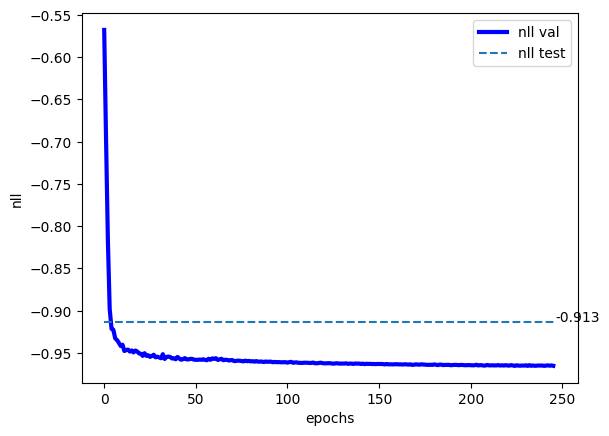

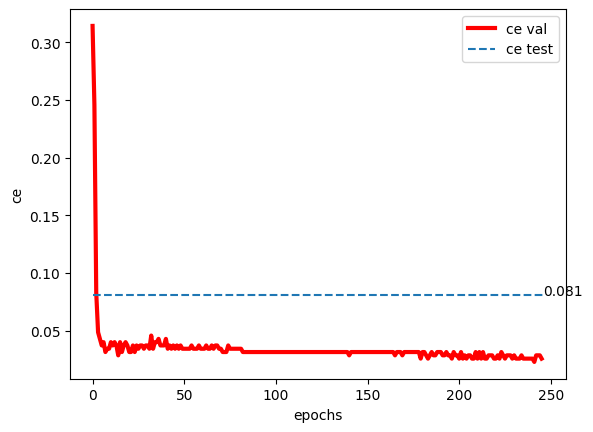

In [23]:
#initialize network from the last generation
net = generator.create_network(x[np.argmin(x)])
 # Init ClassifierNN
model = ClassifierNeuralNet(net) 

# Init OPTIMIZER (here we use ADAMAX)
optimizer = torch.optim.Adamax(
    [p for p in model.parameters() if p.requires_grad == True],
    lr=lr,
    weight_decay=wd,
)

name = "best_classifier" 

# Training procedure
nll_val, error_val = training(
    name=result_dir + name,
    max_patience=max_patience,
    num_epochs=num_epochs,
    model=model,
    optimizer=optimizer,
    training_loader=train_loader,
    val_loader=val_loader,
    print_freq=10, 
)

# The final evaluation (on the test set)
test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
# write the results to a file
f = open(result_dir + name + "_test_loss.txt", "w")
f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
f.close()
# create curves
plot_curve(
    result_dir + name,
    nll_val,
    file_name="_nll_val_curve.pdf",
    ylabel="nll",
    test_eval=test_loss,
)
plot_curve(
    result_dir + name,
    error_val,
    file_name="_ca_val_curve.pdf",
    ylabel="ce",
    color="r-",
    test_eval=test_error,
)

Analysis


In the assignment 4, the classification on the CNN was 0.044. Here it is 0.08 which is a bit higher than the assignment 4. This should be because of that the number of parameters is less in this case. 